<a id='section1'></a>

###Latent Semantic Indexing of Yoga Reviews

Analysis flow in this notebook:

* [Set analysis options](#section2)
* [Analyze NYC reviews](#section3)
* [Analyze LA reviews](#section4)
* [Plot singular values](#section5)
* [Make a few simple checks of our understanding of gensim LSI](#section6)
* [Make 2D plots of the NYC and LA corpora to illustrate latent topics](#section7)
* [Perform LSI and keyword matching queries, and compute document retrieval probabilities](#section8)
* [Investigate 'bikram' query](#section9)
* [Investigate 'prenatal pregnant pregnancy' query](#section10)
* [Investigate 'yoga nidra' query](#section11)
* [Plot document retrieval probabilities for various queries, LA corpus versus NYC corpus](#section12)
* [Create a json file with query info about each business in NYC and LA](#section13)
    
The analysis procedure itself consists of the following steps, separately applied to the NYC and LA corpora:
 1. Concatenate the reviews by yoga business, making sure there are no duplicate reviews for a given business.
 2. Convert to lower case, remove accents, tokenize, and retain only tokens with alphabetical characters.
 3. Remove stop words and proper nouns.
 4. Stem.
 5. Create a corpus dictionary: (integer word ID, word, word frequency in corpus).
 6. Remove tokens that appear too often or not often enough.
 7. Convert each concatenated studio review into bag-of-words format: a list of (token ID, token count) 2-tuples.
 8. Apply tf-idf transformation to corpus.
 9. Apply Latent Semantic Indexing to corpus.
 
Then we perform a few similarity queries against the two corpora and compare.

In [1]:
'''
First get the packages we'll need.
'''
from   pymongo import MongoClient
import logging
import nltk
from   gensim import corpora, models, similarities, matutils, utils
from   collections import defaultdict
from   pprint import pprint
import re
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

<a id='section2'></a>
[Back to top](#section1)

## Set Analysis Options

In [2]:
'''
Set common options for the LSI transformation that will be applied separately
to the NYC and LA corpora.
'''

# SVD algorithm is stochastic.  This does not affect the results of the analysis, except for some 
# plots (since the overall sign of singular vectors can flip depending on the random number).
# To avoid this problem, we set the seed here.
np.random.seed(918273646)

# The following are options for tokenizing, stemming, filtering, etc.
convert_lowercase = True
remove_accents    = True
remove_stopwords  = True
remove_proper     = True # If you enable this, make sure convert_lowercase = True.
stem_tokens       = True
filter_tails      = True
filter_low        = 2    # No dictionary entry for tokens that appear in only 1 document.
filter_up         = 0.80 # No dictionary entry for tokens that appear in more than 80% of the corpus documents.
n_LSI_topics      = 100

# Make list of stopwords.
stoplist = nltk.corpus.stopwords.words('english')
stoplist.append(u'\u0027s')   # "'s" as in "he's"
stoplist.append(u'n\u0027t')  # "n't" as in "he hasn't"
stoplist.append(u'\u0027m')   # "'m" as in "I'm"
stoplist.append(u'ya')        # as in "you"
stoplist.append(u'\u0027ve')  # "'ve" as in "I've"
stoplist.append(u'also')
stoplist.append(u've')
stoplist.append(u'm')
print('List of stopwords: %s' %[str(word) for word in stoplist])

# Make list of proper nouns.
ppn = ["aaron", "aarona", "abigail", "adam", "adelaide", "alan", "alexis", "alice", "alicia", "amalia", 
       "amanda", "andrea", "angela", "angie", "anna", "anne", "annie", "anthony", "anya", "ariel", 
       "ash", "ashley", "audra", 
       "becker", "becky", "belle", "beverly", "bijorn", "bjorn", "brandon", "brian", 
       "caprice", "cara", "carey", "carla", "carlos", "carolyn", "cathy", "charlotte", "chris", 
       "christine", "claire", "connie", "corey", "courtney", 
       "dalton", "daniela", "davey", "david", "deborah", "deena", "diane", "dina", "dr", 
       "eddie", "edwin", "elaine", "elizabeth", "ellen", "emily", "eric", "erica", "erik", "erika", "erin", 
       "ezmy", "fergus", "fern",
       "gabriella", "gavin", "geralyn", "ghylian", "gina", "glenda", 
       "hannah", "harper", "heather", "heidy", "henry", "hermann", "hsiao", "hunt", 
       "ikaika", "ingrid", "ivette", 
       "jacqui", "jahaira", "james", "jane", "janet", "jai", "jen", "jeni", "jenni", "jennie", 
       "jennifer", "jenny", "jess", "jesse", "jessica", "jill", "jillian", "jim", "joe", "joetta", 
       "jose", "joseph", "joy", "joyce", "jq", "judy", "julia", "juliana", "julie", 
       "kalie", "kallie", "karen", "kathleen", "katie", "kaurwar", "ken", "kerri", "kerry", 
       "kim", "kimmy", "kristen",
       "lalita", "lani", "lara", "lauren", "laurie", "liliana", "lilly", "lindsay", "lindsey", 
       "lisa", "liz", "lori", "luisa", "lynn", 
       "madalina", "madison", "maggie", "malaika", "mandy", "marco", "margaret", "marja", "mark", "martha", 
       "masako", "mayuri", "meagan", "megan", "melissa", "melody", "meriany", "merilynn", "mia", 
       "michael", "michelle", "mike", "mimi", "mollie", "molly", "monica", "monika", "morgan", 
       "namgyal", "nancy", "naomi", "narisara", "nathaniel", "nick", "nicola", "nicole", "nikki", "novak",
       "paula", "pauline", "phebe", "politeia", 
       "rachel", "rafael", "ramit", "rebeca", "rebecca", "renee", "richard", "rob", "roger", "rosie", 
       "ruthie", "ryan", 
       "sandhya", "santoshi", "sara", "sarah", "shelly", "sherica", "sheryl", "sonja", "spencer", 
       "stacey", "stacy", "stephan", "stephanie", "stephaine", "steve", "sue", 
       "susan", "suzanne", "suzi", "suzie", 
       "tzaki", "tsewang", "wayne", "wesley", "zander" ]
print
print('Number of proper nouns in removal list = %i' % len(ppn))

# Select the stemmer.
stemmer = nltk.stem.porter.PorterStemmer()

List of stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', '

<a id='section3'></a>
[Back to top](#section1)

## Analyze NYC Reviews

In [3]:
'''
* Make a list of the NYC reviews we'll be analyzing, concatenating by business.
* Tokenize, and if enabled, remove stopwords and proper nouns, and stem.
* Create a corpus dictionary: (integer word ID, word, word frequency in corpus),
  removing words that appear too infrequently or too frequently.
* Convert the tokenized reviews of the corpus to bags of words.
* Apply tf-idf transformation to corpus.
* Apply Latent Semantic Indexing to the corpus.
* Index LSI corpus for later use with queries.
'''

# Initialize output lists:
NYC_names    = []
NYC_reviews  = []
NYC_ratings  = []
NYC_websites = []

client = MongoClient()
yoga   = client.dsbc.yyrnyc
print('Opening NYC database...')
print('Total number of Yoga businesses = %i' %yoga.count())

cursor = yoga.find()
for record in cursor:
    reviews = []
    for review in record["usr_text"]:
        if review:
            reviews.append(review)

    # Eliminate duplicate reviews for a given studio
    # (different studios may still "share" a review):
    n_reviews = len(reviews)
    ureviews  = []
    for review in set(reviews):
        ureviews.append(review)
    n_ureviews = len(ureviews)
    if n_ureviews > 300:
        print('Business %s has %i reviews' %(record["biz_name"],n_ureviews))
    
    # Concatenate the unique reviews by business.
    con_review = ""
    for review in ureviews:
        con_review += " " + review

    if con_review:
        con_review += " " + record["biz_name"] # Add business name string only if there are reviews
        studio = record["biz_name"]+" [at] "+record["biz_address"]
        NYC_names.append(studio)
        NYC_reviews.append(con_review)
        NYC_ratings.append(record["biz_rating"])
        NYC_websites.append(record["biz_website"])

print('Number of reviewed NYC Yoga businesses = %i' % len(NYC_reviews))

# Tokenize, removing punctuation and numbers, and if enabled, convert to lower case and remove accents.
NYC_reviews_1 = [list(utils.tokenize(studio_review,lowercase=convert_lowercase,
                 deacc=remove_accents)) for studio_review in NYC_reviews]

if remove_stopwords:
    NYC_reviews_2 = [[word for word in studio_review if word not in stoplist] 
                     for studio_review in NYC_reviews_1]
    NYC_reviews_1 = NYC_reviews_2[:]

if remove_proper:
    NYC_reviews_2 = [[word for word in studio_review if word not in ppn] 
                     for studio_review in NYC_reviews_1]
    NYC_reviews_1 = NYC_reviews_2[:]

if stem_tokens:
    NYC_reviews_2 = [[stemmer.stem(word) for word in studio_review] for studio_review in NYC_reviews_1]
    NYC_reviews_1 = NYC_reviews_2[:]

NYC_dictionary = corpora.Dictionary( NYC_reviews_1 )
if filter_tails:
    NYC_dictionary.filter_extremes( no_below=filter_low, no_above=filter_up, keep_n=None )
print(NYC_dictionary)
n_terms  = len(NYC_dictionary)
n_docs   = len(NYC_reviews_1)
if n_LSI_topics <= 0:
    n_sv_nyc = min( n_terms, n_docs )
else:
    n_sv_nyc = n_LSI_topics
print('In NYC corpus: Number of terms = %i, documents = %i, latent topics = %i' % (n_terms,n_docs,n_sv_nyc))

NYC_corpus_bow = [NYC_dictionary.doc2bow(studio_review) for studio_review in NYC_reviews_1]

NYC_tfidf = models.TfidfModel(NYC_corpus_bow)
NYC_corpus_tfidf = NYC_tfidf[NYC_corpus_bow]

NYC_lsi = models.LsiModel( NYC_corpus_tfidf, id2word=NYC_dictionary, num_topics=n_sv_nyc, 
                           onepass=False, power_iters=2 )
NYC_corpus_lsi = NYC_lsi[NYC_corpus_tfidf]

NYC_index = similarities.MatrixSimilarity( NYC_corpus_lsi, num_features=n_sv_nyc ) 

Opening NYC database...
Total number of Yoga businesses = 796
Business Yoga to the People has 331 reviews
Number of reviewed NYC Yoga businesses = 560
Dictionary(8462 unique tokens: [u'fawn', u'yellow', u'interchang', u'four', u'betch']...)
In NYC corpus: Number of terms = 8462, documents = 560, latent topics = 100


<a id='section4'></a>
[Back to top](#section1)

## Analyze LA Reviews

In [4]:
'''
* Make a list of the LA reviews we'll be analyzing, concatenating by business.
* Tokenize, and if enabled, remove stopwords and proper nouns, and stem.
* Create a corpus dictionary: (integer word ID, word, word frequency in corpus),
  removing words that appear too infrequently or too frequently.
* Convert the tokenized reviews of the corpus to bags of words.
* Apply tf-idf transformation to corpus.
* Apply Latent Semantic Indexing to the corpus.
* Index LSI corpus for later use with queries.
'''


# Initialize output lists:
LA_names    = []
LA_reviews  = []
LA_ratings  = []
LA_websites = []

client = MongoClient()
yoga   = client.dsbc.yyrla
print('Opening LA database...')
print('Total number of Yoga businesses = %i' %yoga.count())

cursor = yoga.find()
for record in cursor:
    reviews = []
    for review in record["usr_text"]:
        if review:
            reviews.append(review)

    # Eliminate duplicate reviews for a given studio
    # (different studios may still "share" a review):
    n_reviews = len(reviews)
    ureviews  = []
    for review in set(reviews):
        ureviews.append(review)
    n_ureviews = len(ureviews)
    if n_ureviews > 300:
        print('Business %s has %i reviews' %(record["biz_name"],n_ureviews))
    
    # Concatenate the unique reviews by business.
    con_review = ""
    for review in ureviews:
        con_review += " " + review

    if con_review:
        con_review += " " + record["biz_name"] # Add business name string only if there are reviews
        studio = record["biz_name"]+" [at] "+record["biz_address"]
        LA_names.append(studio)
        LA_reviews.append(con_review)
        LA_ratings.append(record["biz_rating"])
        LA_websites.append(record["biz_website"])

print('Number of reviewed LA Yoga businesses = %i' % len(LA_reviews))

# Tokenize, removing punctuation and numbers, and if enabled, convert to lower case and remove accents.
LA_reviews_1 = [list(utils.tokenize(studio_review,lowercase=convert_lowercase,
                deacc=remove_accents)) for studio_review in LA_reviews]

if remove_stopwords:
    LA_reviews_2 = [[word for word in studio_review if word not in stoplist] 
                    for studio_review in LA_reviews_1]
    LA_reviews_1 = LA_reviews_2[:]

if remove_proper:
    LA_reviews_2 = [[word for word in studio_review if word not in ppn] 
                    for studio_review in LA_reviews_1]
    LA_reviews_1 = LA_reviews_2[:]

if stem_tokens:
    LA_reviews_2 = [[stemmer.stem(word) for word in studio_review] for studio_review in LA_reviews_1]
    LA_reviews_1 = LA_reviews_2[:]
    
LA_dictionary = corpora.Dictionary( LA_reviews_1 )
if filter_tails:
    LA_dictionary.filter_extremes( no_below=filter_low, no_above=filter_up, keep_n=None )
print(LA_dictionary)
n_terms = len(LA_dictionary)
n_docs  = len(LA_reviews_1)
if n_LSI_topics <= 0:
    n_sv_la = min( n_terms, n_docs )
else:
    n_sv_la = n_LSI_topics
print('In LA corpus: Number of terms = %i, documents = %i, latent topics = %i' % (n_terms,n_docs,n_sv_la))

LA_corpus_bow = [LA_dictionary.doc2bow(studio_review) for studio_review in LA_reviews_1]

LA_tfidf = models.TfidfModel(LA_corpus_bow)
LA_corpus_tfidf = LA_tfidf[LA_corpus_bow]

LA_lsi = models.LsiModel( LA_corpus_tfidf, id2word=LA_dictionary, num_topics=n_sv_la, 
                          onepass=False, power_iters=2 )
LA_corpus_lsi = LA_lsi[LA_corpus_tfidf]

LA_index = similarities.MatrixSimilarity( LA_corpus_lsi, num_features=n_sv_la ) 

Opening LA database...
Total number of Yoga businesses = 749
Business Runyon Canyon Park has 1285 reviews
Business Gold?s Gym Downtown Los Angeles has 380 reviews
Business 24 Hour Fitness has 426 reviews
Business 24 Hour Fitness has 304 reviews
Business LA Fitness has 317 reviews
Number of reviewed LA Yoga businesses = 749
Dictionary(13667 unique tokens: [u'fawn', u'woodi', u'yellow', u'interchang', u'elvi']...)
In LA corpus: Number of terms = 13667, documents = 749, latent topics = 100


<a id='section5'></a>
[Back to top](#section1)

## Plot Singular Values
Warning: The following two cells require that all the previous cells be run with n_LSI_topics=0 (which forces the SVD algorithm to use the maximum number of singular vectors or latent topics).  Some of the results in the two cells below will be meaningless when run with the standard value n_LSI_topics=100, hence the if statement at the beginning of each cell.

Quadrature difference between singular value calculations = 0.000001
 
Total Variance = 560.000000
Explained Variance = 70% of total at Singular Value = 0.919793 (ranking 241).
Number of non-zero singular values = 557.
 


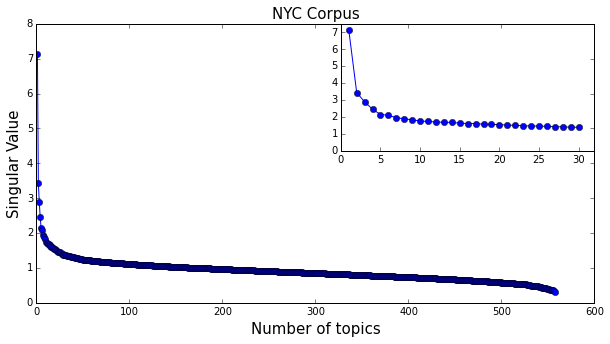

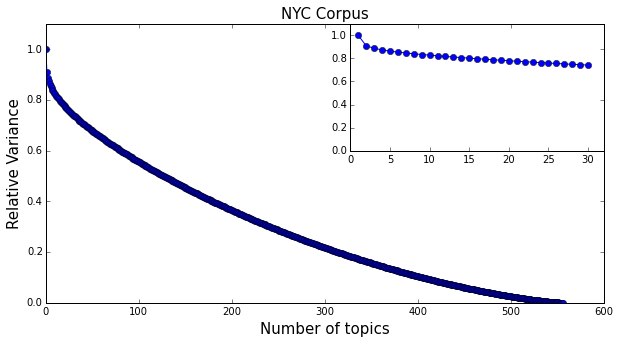

Shape of U matrix = (8447, 557)
 
Top 20 Topics:
--------------
0: SV=7.130:  0.185*studio + 0.129*gym + 0.128*bikram + 0.121*room + 0.111*hot + 0.109*teacher
1: SV=3.432: -0.538*gym - 0.308*machin - 0.300*crunch - 0.194*trainer - 0.177*equip - 0.145*weight
2: SV=2.882:  0.576*bikram + 0.260*hot - 0.204*massag + 0.169*room + 0.152*locker + 0.143*carpet
3: SV=2.447: -0.688*massag - 0.271*facial - 0.197*spa - 0.166*exhal - 0.150*bikram - 0.133*thai
4: SV=2.135:  0.468*pilat - 0.305*dahn + 0.244*zumba - 0.244*medit + 0.194*reform - 0.176*center
5: SV=2.089: -0.378*bikram - 0.316*pilat - 0.188*dahn - 0.159*zumba - 0.138*session + 0.129*yogawork
6: SV=1.952: -0.352*prenat - 0.327*pregnanc + 0.291*dahn - 0.172*pregnant + 0.167*barr + 0.153*medit
7: SV=1.880: -0.604*zumba + 0.196*pilat - 0.190*prenat - 0.148*kid - 0.138*danc - 0.136*pregnanc
8: SV=1.821:  0.347*prenat + 0.322*dahn + 0.316*pregnanc + 0.165*pregnant + 0.159*pilat - 0.154*zumba
9: SV=1.751: -0.233*pilat + 0.215*lululemon - 0.205

In [5]:
'''
Check singular value calculation and plot singular values versus number of topics for NYC corpus.
'''
if n_LSI_topics > 0:
    print('Number of latent topics must equal number of dictionary terms for this to work.')
else:
    region = "NYC"
    sv    = NYC_lsi.projection.s
    np_sv = np.linalg.svd(matutils.corpus2dense(NYC_corpus_lsi,n_sv_nyc))
    test  = np.sqrt(sum([(np_sv[1][i]-sv[i])**2 for i in range(len(sv))]))
    print('Quadrature difference between singular value calculations = %f' % test)

    print(" ")
    total_variance = sum([sv[i]**2 for i in range(len(sv))])
    print("Total Variance = %f" %total_variance)

    partial_variance = 0
    old_explained_variance = 0
    nonzero_sv = 0
    for ind,value in enumerate(sv):
        if value != 0:
            nonzero_sv += 1
        partial_variance += value**2
        explained_variance = partial_variance/total_variance
        if old_explained_variance<0.70 and explained_variance >=0.70:
            print('Explained Variance = 70%% of total at Singular Value = %f (ranking %i).' %(value,ind+1))
        old_explained_variance = explained_variance
    print('Number of non-zero singular values = %i.' % nonzero_sv)
    print(' ')

    # Plot singular values versus number of topics
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
    ax.plot( range(1,len(sv)+1), sv, '-o' )
    ax.set_xlabel( 'Number of topics', fontsize=15)
    ax.set_ylim(0.0,8.0)
    ax.set_ylabel( 'Singular Value', fontsize=15 )
    ax.set_title( region+" Corpus", fontsize=15 )
    subax = fig.add_subplot( 2, 2, 2 )
    subax.plot( range(1,31), sv[:30], '-o' )
    subax.set_xlim( 0.0, 32.0 )
    subax.set_ylim( 0.0, 7.5 )
    subax.tick_params( axis='x', which='both', top='off' )
    subax.tick_params( axis='y', which='both', right='off' )
    plt.show()
    # fig.savefig("nyc_singular_values.pdf")

    # Plot relative error on approximation to term-document matrix
    # (using Frobenius norm), as a function of number of topics kept.
    psssv = [0.0]*(len(sv)+1)
    for i in range(len(sv)-1,-1,-1):
        psssv[i] = psssv[i+1] + sv[i]**2
    for i in range(len(sv)):
        psssv[i] /= total_variance
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
    ax.plot( range(0,len(sv)), psssv[0:len(sv)], '-o' )
    ax.set_xlabel( 'Number of topics', fontsize=15)
    ax.set_ylim(0.0,1.1)
    ax.set_ylabel( 'Relative Variance', fontsize=15 )
    ax.set_title( region+" Corpus", fontsize=15 )
    subax = fig.add_subplot( 2, 2, 2 )
    subax.plot( range(1,31), psssv[:30], '-o' )
    subax.set_xlim( 0.0, 32.0 )
    subax.set_ylim( 0.0, 1.1 )
    subax.tick_params( axis='x', which='both', top='off' )
    subax.tick_params( axis='y', which='both', right='off' )
    plt.show()
    # fig.savefig("nyc_relative_variance.pdf")

    umatrix = NYC_lsi.projection.u
    print('Shape of U matrix = %s' % str(umatrix.shape))
    nwords  = 6
    ntopics = min(len(umatrix[0]),2000)
    max_print = min(20,ntopics)
    print(" ")
    print("Top %i Topics:" % max_print)
    print("--------------")
    term_list = [i for i in range(len(NYC_dictionary))]
    for jnd,vector in enumerate(zip(*umatrix)):
        out_string = "{:d}".format(jnd)+": SV="+"{:.3f}".format(sv[jnd])+": "
        for ind,x in enumerate(sorted(zip(vector,term_list),key=lambda x: -abs(x[0]))[:nwords]):
            word = NYC_dictionary[x[1]]
            if x[0]>0.0:
                if ind>0:
                    out_string += " + "+"{:.3f}".format(x[0])+"*"+word
                else:
                    out_string += " "+"{:.3f}".format(x[0])+"*"+word
            else:
                if ind>0:
                    out_string += " - "+"{:.3f}".format(abs(x[0]))+"*"+word
                else:
                    out_string += "-"+"{:.3f}".format(abs(x[0]))+"*"+word
        print(out_string)
        if jnd == max_print-1:
            break

    #lsi.show_topics( num_topics=ntopics, num_words=nwords, log=False, formatted=True )

Quadrature difference between singular value calculations = 0.000001
 
Total Variance = 749.000000
Explained Variance = 70% of total at Singular Value = 0.939616 (ranking 305).
Number of non-zero singular values = 748.
 


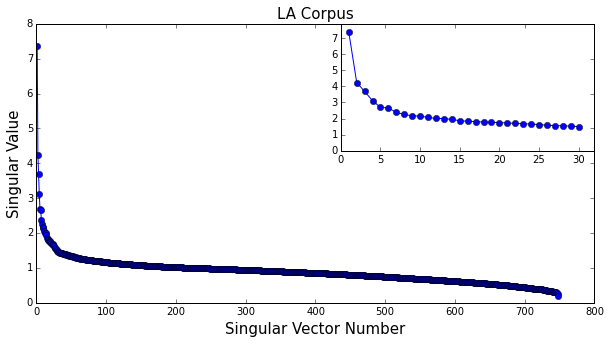

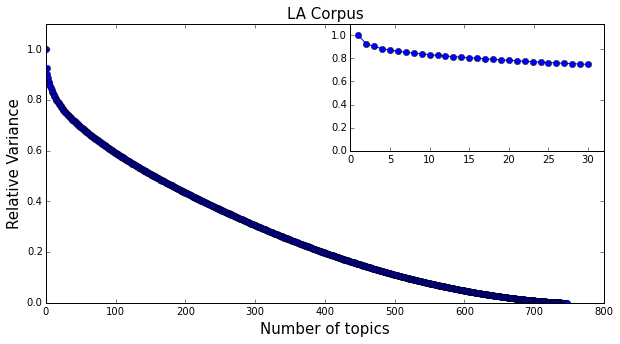

Shape of U matrix = (13651, 748)
 
Top 20 Topics:
--------------
0: SV=7.376:  0.201*studio + 0.176*gym + 0.156*pilat + 0.152*massag + 0.123*instructor + 0.116*workout
1: SV=4.243:  0.813*massag + 0.263*thai + 0.130*masseus - 0.115*gym + 0.109*therapist + 0.102*spa
2: SV=3.685:  0.496*gym - 0.245*studio + 0.219*machin - 0.214*pilat + 0.188*locker + 0.172*pool
3: SV=3.106: -0.653*pilat - 0.223*reform + 0.204*bikram + 0.148*hot - 0.138*workout + 0.137*studio
4: SV=2.698:  0.475*barr + 0.258*physiqu + 0.249*pop + 0.214*bar + 0.165*method - 0.130*acupunctur
5: SV=2.654: -0.441*pilat + 0.212*barr - 0.197*bikram + 0.195*crossfit - 0.186*studio - 0.177*reform
6: SV=2.381:  0.467*pole + 0.452*danc + 0.195*zumba - 0.186*acupunctur + 0.184*aerial - 0.176*bikram
7: SV=2.255:  0.387*crossfit - 0.306*acupunctur - 0.202*treatment + 0.198*bikram + 0.191*trainer + 0.158*coach
8: SV=2.165: -0.411*bikram - 0.320*pole + 0.294*spin - 0.198*acupunctur - 0.174*hot - 0.164*crossfit
9: SV=2.152: -0.577*spin -

In [16]:
'''
Check singular value calculation and plot singular values versus number of topics for LA corpus.
'''
if n_LSI_topics > 0:
    print('Number of latent topics must equal number of dictionary terms for this to work.')
else:
    region = "LA"
    sv    = LA_lsi.projection.s
    np_sv = np.linalg.svd(matutils.corpus2dense(LA_corpus_lsi,n_sv_la))
    test  = np.sqrt(sum([(np_sv[1][i]-sv[i])**2 for i in range(len(sv))]))
    print('Quadrature difference between singular value calculations = %f' % test)

    print(" ")
    total_variance = sum([sv[i]**2 for i in range(len(sv))])
    print("Total Variance = %f" %total_variance)

    partial_variance = 0
    old_explained_variance = 0
    nonzero_sv = 0
    for ind,value in enumerate(sv):
        if value != 0:
            nonzero_sv += 1
        partial_variance += value**2
        explained_variance = partial_variance/total_variance
        if old_explained_variance<0.70 and explained_variance >=0.70:
            print('Explained Variance = 70%% of total at Singular Value = %f (ranking %i).' %(value,ind+1))
        old_explained_variance = explained_variance
    print('Number of non-zero singular values = %i.' % nonzero_sv)
    print(' ')

    # Plot singular values versus number of topics
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
    ax.plot( range(1,len(sv)+1), sv, '-o' )
    ax.set_xlabel( 'Singular Vector Number', fontsize=15)
    ax.set_ylim(0.0,8.0)
    ax.set_ylabel( 'Singular Value', fontsize=15 )
    ax.set_title( region+" Corpus", fontsize=15 )
    subax = fig.add_subplot( 2, 2, 2 )
    subax.plot( range(1,31), sv[:30], '-o' )
    subax.set_xlim( 0.0, 32.0 )
    subax.set_ylim( 0.0, 7.9 )
    subax.tick_params( axis='x', which='both', top='off' )
    subax.tick_params( axis='y', which='both', right='off' )
    plt.show()
    # fig.savefig("LA_Singular_Values.png")

    # Plot relative error on approximation to term-document matrix
    # (using Frobenius norm), as a function of number of topics kept.
    psssv = [0.0]*(len(sv)+1)
    for i in range(len(sv)-1,-1,-1):
        psssv[i] = psssv[i+1] + sv[i]**2
    for i in range(len(sv)):
        psssv[i] /= total_variance
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
    ax.plot( range(0,len(sv)), psssv[0:len(sv)], '-o' )
    ax.set_xlabel( 'Number of topics', fontsize=15)
    ax.set_ylim(0.0,1.1)
    ax.set_ylabel( 'Relative Variance', fontsize=15 )
    ax.set_title( region+" Corpus", fontsize=15 )
    subax = fig.add_subplot( 2, 2, 2 )
    subax.plot( range(1,31), psssv[:30], '-o' )
    subax.set_xlim( 0.0, 32.0 )
    subax.set_ylim( 0.0, 1.1 )
    subax.tick_params( axis='x', which='both', top='off' )
    subax.tick_params( axis='y', which='both', right='off' )
    plt.show()
    # fig.savefig("la_relative_variance.pdf")

    umatrix = LA_lsi.projection.u
    print('Shape of U matrix = %s' % str(umatrix.shape))
    nwords  = 6
    ntopics = min(len(umatrix[0]),2000)
    max_print = min(20,ntopics)
    print(" ")
    print("Top %i Topics:" % max_print)
    print("--------------")
    term_list = [i for i in range(len(LA_dictionary))]
    for jnd,vector in enumerate(zip(*umatrix)):
        out_string = "{:d}".format(jnd)+": SV="+"{:.3f}".format(sv[jnd])+": "
        for ind,x in enumerate(sorted(zip(vector,term_list),key=lambda x: -abs(x[0]))[:nwords]):
            word = LA_dictionary[x[1]]
            if x[0]>0.0:
                if ind>0:
                    out_string += " + "+"{:.3f}".format(x[0])+"*"+word
                else:
                    out_string += " "+"{:.3f}".format(x[0])+"*"+word
            else:
                if ind>0:
                    out_string += " - "+"{:.3f}".format(abs(x[0]))+"*"+word
                else:
                    out_string += "-"+"{:.3f}".format(abs(x[0]))+"*"+word
        print(out_string)
        if jnd == max_print-1:
            break

    #lsi.show_topics( num_topics=ntopics, num_words=nwords, log=False, formatted=True )

<a id='section6'></a>
[Back to top](#section1)

## Make a few simple checks of our understanding of gensim LSI

In [6]:
# Get the V*Sigma, V, and U matrices (V=right-singular vectors, U=left-singular vectors, Sigma=singular values).
vsmatrix = matutils.corpus2dense(NYC_corpus_lsi, len(NYC_lsi.projection.s)).T
vmatrix  = vsmatrix / NYC_lsi.projection.s
print('Shape of V matrix = %s' % str(vmatrix.shape))
umatrix = NYC_lsi.projection.u
print('Shape of U matrix = %s' % str(umatrix.shape))
print

# Check normalization of V matrix and document vectors.  These normalizations are 1 if all singular 
# values are used, otherwise they are less than 1.  If the LSI transformation is done on something 
# else than the tf-idf corpus, the document normalizations may be different from 1 in any case.
print('Normalizations:')
for idoc in range(10):
    rsvnorm = np.sqrt(sum([vmatrix[idoc][ind]**2 for ind in range(vmatrix.shape[1])]))
    docnorm = np.sqrt(sum([vsmatrix[idoc][ind]**2 for ind in range(vsmatrix.shape[1])]))
    print('Right-singular vector %i: %f; document %i: %f' %(idoc,rsvnorm,idoc,docnorm))
print

# Check LSI coordinates of documents; we should have V*Sigma = X.T*U, where X.T is the transpose of X, 
# and X is the term-document matrix of the corpus.
print('Projections on first 4 left-singular vectors:')
sumsq = 0.0
for idoc,doc in enumerate(NYC_corpus_tfidf):
    uproj1 = [sum([attr_value*umatrix[attr_id][ivec] for attr_id,attr_value in doc]) for ivec in range(4)]
    uproj2 = [vsmatrix[idoc][ivec] for ivec in range(4)]
    sumsq += sum((x1-x2)**2 for (x1,x2) in zip(uproj1,uproj2))
    if idoc < 10:
        print('Document {:d}: [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(idoc,uproj1[0],uproj1[1],uproj1[2],uproj1[3]))
        print('            [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(uproj2[0],uproj2[1],uproj2[2],uproj2[3]))
print('Sum of squared differences = %f' % sumsq)
print

# Check cosine similarity calculations for queries.
print('Cosine similarity calculations:')
query     = "gym, machines, equipment, trainer, and crunch"
query1    = utils.tokenize(query,lowercase=convert_lowercase,deacc=remove_accents)
if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
if remove_proper:    query1 = [word for word in query1 if word not in ppn]
if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
vec_bow   = NYC_dictionary.doc2bow(query1,allow_update=False)
print('Query =        "%s"' %(query))
print('Bag of words = "%s"' %([str(NYC_dictionary[ind[0]]) for ind in vec_bow]))
vec_tfidf = NYC_tfidf[vec_bow]
vec_lsi   = NYC_lsi[vec_tfidf]
sims      = NYC_index[vec_lsi]

sumsq = 0.0
qq = np.sqrt(sum([value*value for (ind,value) in vec_lsi]))
for idoc in range(len(NYC_names)):
    dd = np.sqrt(sum([vsmatrix[idoc][ind]**2 for ind in range(vsmatrix.shape[1])]))
    qd = sum([value*vsmatrix[idoc][ind] for (ind,value) in vec_lsi])
    cosim = qd/(dd*qq)
    sumsq += (cosim-sims[idoc])**2
    if idoc < 10: print('Document %i: cosine similarity = %f, %f' %(idoc,cosim,sims[idoc]))
print('Sum of squared differences = %f' %sumsq)

Shape of V matrix = (560, 100)
Shape of U matrix = (8462, 100)

Normalizations:
Right-singular vector 0: 0.455684; document 0: 0.598031
Right-singular vector 1: 0.412108; document 1: 0.519096
Right-singular vector 2: 0.463581; document 2: 0.804998
Right-singular vector 3: 0.290779; document 3: 0.546632
Right-singular vector 4: 0.351454; document 4: 0.633431
Right-singular vector 5: 0.227193; document 5: 0.627366
Right-singular vector 6: 0.271416; document 6: 0.590521
Right-singular vector 7: 0.306096; document 7: 0.479267
Right-singular vector 8: 0.317484; document 8: 0.739310
Right-singular vector 9: 0.415445; document 9: 0.759849

Projections on first 4 left-singular vectors:
Document 0: [0.215194, -0.094545, 0.089359, 0.067048]
            [0.215194, -0.094545, 0.089359, 0.067048]
Document 1: [0.152920, -0.073820, 0.048919, 0.053677]
            [0.152920, -0.073820, 0.048919, 0.053677]
Document 2: [0.454401, -0.100966, 0.049783, 0.039344]
            [0.454401, -0.100966, 0.049783,

<a id='section7'></a>
[Back to top](#section1)

## Make 2D-plots of the NYC and LA corpora to illustrate latent topics. 

Shape of V*S matrix = (560, 100)
Query = "gym and fitness club", bag of words = "['fit', 'club', 'gym']"
Query = "bikram and hot yoga", bag of words = "['hot', 'bikram']"
Query = "massage, facial, spa", bag of words = "['spa', 'massag', 'facial']"
 
Number of blue dots = 33
Number of green dots = 67
Number of black dots = 7
Number of red dots = 95
Number of yellow dots = 358
Total number of dots = 560


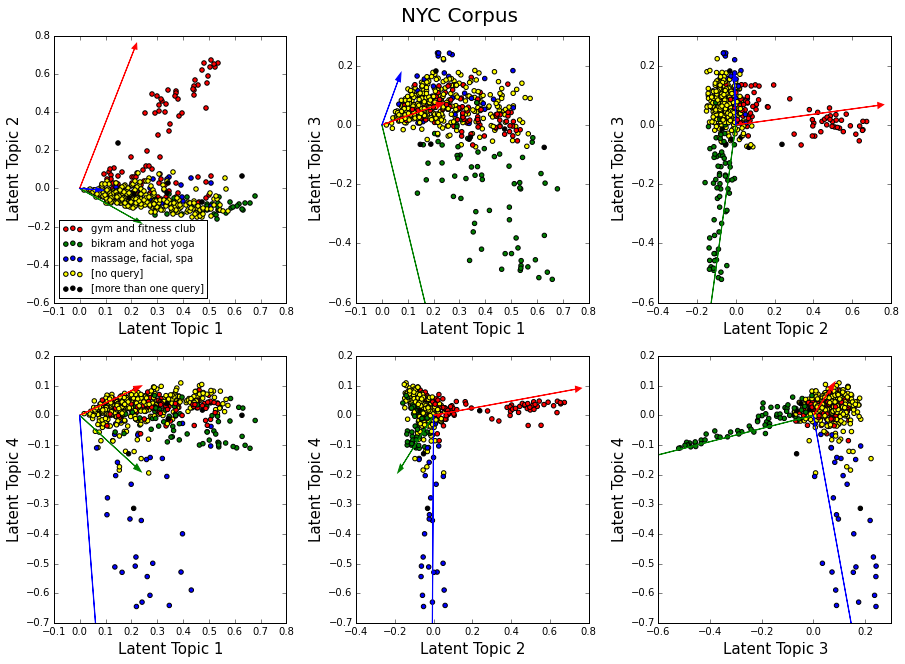

In [7]:
'''
Plot NYC corpus documents in 2D latent space.
Note that latent topics are nested, so that for example, the first two topics are 
always the same, regardless of whether one specifies num_topics=2 or num_topics=1000
when applying the LSI transformation.  In other words, it is not necessary to redo
the LSI transformation for the purpose of a 2D plot.
'''
region    = "NYC"
# Compute document-topic matrix times matrix of singular values
vsmatrix  = matutils.corpus2dense(NYC_corpus_lsi, len(NYC_lsi.projection.s)).T
print('Shape of V*S matrix = %s' % str(vsmatrix.shape))

# Prepare some queries against the corpus
tqueries  = ["gym and fitness club", "bikram and hot yoga", "massage, facial, spa"]
qcolors   = ["red", "green", "blue"]
acolors   = qcolors[:]
acolors.extend(["yellow","black"])
labels    = tqueries[:]
labels.extend(["[no query]", "[more than one query]"])
cutoffs   = [0.1, 0.1, 0.1]
nqueries  = len(tqueries)
colors    = ["yellow" for ind in range(vsmatrix.shape[0])]
sims      = {}
counts    = defaultdict(int)
counts["black"] = 0
counts["yellow"] = len(colors)
qarrow    = [[0.0 for _ in range(vsmatrix.shape[1])] for _ in range(nqueries)]
for iq,(query,qcolor,cutoff) in enumerate(zip(tqueries,qcolors,cutoffs)):
    query1         = utils.tokenize(query,lowercase=convert_lowercase,deacc=remove_accents)
    if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
    if remove_proper:    query1 = [word for word in query1 if word not in ppn]
    if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
    vec_bow        = NYC_dictionary.doc2bow(query1,allow_update=False)
    print('Query = "%s", bag of words = "%s"' %(query,[str(NYC_dictionary[ind[0]]) for ind in vec_bow]))
    vec_tfidf      = NYC_tfidf[vec_bow]
    vec_lsi        = NYC_lsi[vec_tfidf]
    for ind,value in vec_lsi:
        qarrow[iq][ind] = value
    sims[qcolor]   = NYC_index[vec_lsi]
    counts[qcolor] = 0
    for ind in range(len(sims[qcolor])):
        if sims[qcolor][ind] > cutoff:
            for color in acolors:
                if colors[ind] == color:
                    counts[color] -= 1
            if colors[ind] == "yellow":
                colors[ind] = qcolor
                counts[qcolor] += 1
            else:
                colors[ind] = "black"
                counts["black"] += 1

for iq in range(nqueries):
    qanorm = np.sqrt(sum([qarrow[iq][i]**2 for i in range(vsmatrix.shape[1])]))
    qarrow[iq] /= qanorm
print(" ")
for key,value in counts.items():
    print('Number of %s dots = %i' %(key,value))
print('Total number of dots = %i' %(sum([counts[color] for color in acolors])))

# Plot corpus documents in 2D latent space.
xval = [vsmatrix[i][0] for i in range(vsmatrix.shape[0])]
yval = [vsmatrix[i][1] for i in range(vsmatrix.shape[0])]
zval = [vsmatrix[i][2] for i in range(vsmatrix.shape[0])]
aval = [vsmatrix[i][3] for i in range(vsmatrix.shape[0])]
fig, ax = plt.subplots( nrows=2, ncols=3, figsize=(15,10) )
plt.subplots_adjust( wspace=0.30, hspace=0.20, top=0.94 )
plt.suptitle("NYC Corpus", fontsize=20)
for ind,color in enumerate(acolors):
    px = [xval[i] for i in range(len(xval)) if colors[i]==color]
    py = [yval[i] for i in range(len(yval)) if colors[i]==color]
    ax[0,0].scatter( px, py, c=color, label=labels[ind] )
ax[0,0].set_xlabel( 'Latent Topic 1', fontsize=15 )
ax[0,0].set_ylabel( 'Latent Topic 2', fontsize=15 )
ax[0,0].set_ylim( -0.60, 0.80 )
for iq in range(nqueries):
    ax[0,0].arrow(0.0, 0.0, qarrow[iq][0], qarrow[iq][1], fc=qcolors[iq], ec=qcolors[iq] )
#ax.arrow(0, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax[0,0].legend(prop={'size': 10},loc="lower left")
ax[0,1].scatter( xval, zval, c=colors )
ax[0,1].set_xlabel( 'Latent Topic 1', fontsize=15 )
ax[0,1].set_ylabel( 'Latent Topic 3', fontsize=15 )
for iq in range(nqueries):
    ax[0,1].arrow(0.0, 0.0, qarrow[iq][0], qarrow[iq][2], fc=qcolors[iq], ec=qcolors[iq] )
ax[0,2].scatter( yval, zval, c=colors )
ax[0,2].set_xlabel( 'Latent Topic 2', fontsize=15 )
ax[0,2].set_ylabel( 'Latent Topic 3', fontsize=15 )
for iq in range(nqueries):
    ax[0,2].arrow(0.0, 0.0, qarrow[iq][1], qarrow[iq][2], fc=qcolors[iq], ec=qcolors[iq] )
ax[1,0].scatter( xval, aval, c=colors )
ax[1,0].set_xlabel( 'Latent Topic 1', fontsize=15 )
ax[1,0].set_ylabel( 'Latent Topic 4', fontsize=15 )
for iq in range(nqueries):
    ax[1,0].arrow(0.0, 0.0, qarrow[iq][0], qarrow[iq][3], fc=qcolors[iq], ec=qcolors[iq] )
ax[1,1].scatter( yval, aval, c=colors )
ax[1,1].set_xlabel( 'Latent Topic 2', fontsize=15 )
ax[1,1].set_ylabel( 'Latent Topic 4', fontsize=15 )
for iq in range(nqueries):
    ax[1,1].arrow(0.0, 0.0, qarrow[iq][1], qarrow[iq][3], fc=qcolors[iq], ec=qcolors[iq] )
ax[1,2].scatter( zval, aval, c=colors )
ax[1,2].set_xlabel( 'Latent Topic 3', fontsize=15 )
ax[1,2].set_ylabel( 'Latent Topic 4', fontsize=15 )
for iq in range(nqueries):
    ax[1,2].arrow(0.0, 0.0, qarrow[iq][2], qarrow[iq][3], fc=qcolors[iq], ec=qcolors[iq] )
plt.show()

Shape of V*S matrix = (749, 100)
red query = "massage, facial, spa", bag of words = "['massag', 'spa', 'facial']"
green query = "gym and fitness club", bag of words = "['fit', 'club', 'gym']"
blue query = "pilates", bag of words = "['pilat']"
turquoise query = "bikram and hot yoga", bag of words = "['hot', 'bikram']"
 
Number of blue dots = 53
Number of turquoise dots = 37
Number of yellow dots = 444
Number of green dots = 109
Number of black dots = 42
Number of red dots = 64
Total number of dots = 749


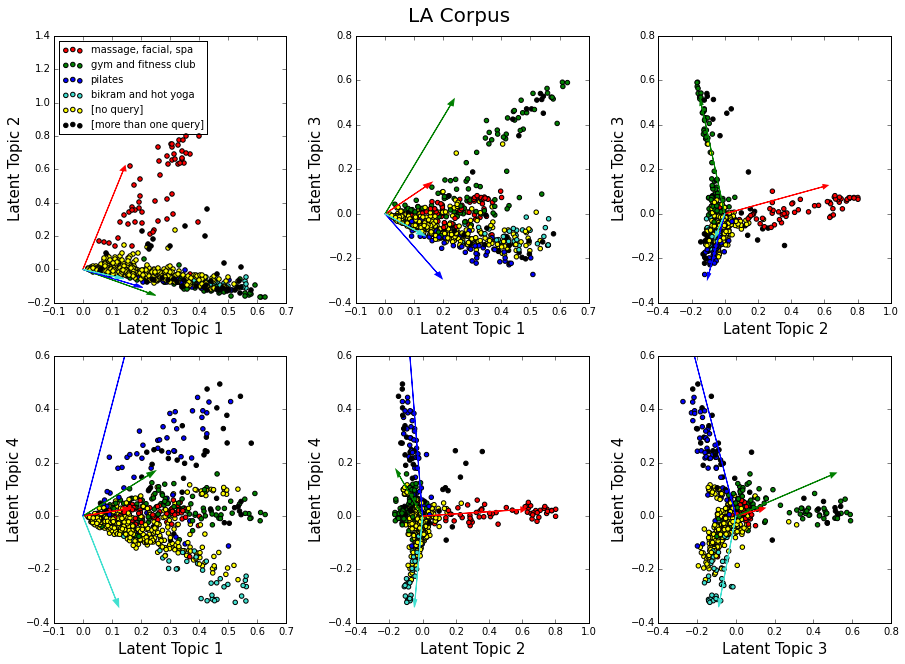

In [8]:
'''
Plot LA corpus documents in 2D latent space.
'''
region    = "LA"
# Compute document-topic matrix times matrix of singular values
vsmatrix  = matutils.corpus2dense(LA_corpus_lsi, len(LA_lsi.projection.s)).T
print('Shape of V*S matrix = %s' % str(vsmatrix.shape))

# Prepare some queries against the corpus
tqueries  = ["massage, facial, spa", "gym and fitness club", "pilates", "bikram and hot yoga"]
qcolors   = ["red", "green", "blue", "turquoise"]
acolors   = qcolors[:]
acolors.extend(["yellow","black"])
labels    = tqueries[:]
labels.extend(["[no query]", "[more than one query]"])
cutoffs   = [0.1, 0.1, 0.1, 0.1]
nqueries  = len(tqueries)
colors    = ["yellow" for ind in range(vsmatrix.shape[0])]
sims      = {}
counts    = defaultdict(int)
counts["black"] = 0
counts["yellow"] = len(colors)
qarrow    = [[0.0 for _ in range(vsmatrix.shape[1])] for _ in range(nqueries)]
for iq,(query,qcolor,cutoff) in enumerate(zip(tqueries,qcolors,cutoffs)):
    query1         = utils.tokenize(query,lowercase=convert_lowercase,deacc=remove_accents)
    if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
    if remove_proper:    query1 = [word for word in query1 if word not in ppn]
    if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
    vec_bow        = LA_dictionary.doc2bow(query1,allow_update=False)
    print('%s query = "%s", bag of words = "%s"' %(qcolor,query,[str(LA_dictionary[ind[0]]) for ind in vec_bow]))
    vec_tfidf      = LA_tfidf[vec_bow]
    vec_lsi        = LA_lsi[vec_tfidf]
    for ind,value in vec_lsi:
        qarrow[iq][ind] = value
    sims[qcolor]   = LA_index[vec_lsi]
    counts[qcolor] = 0
    for ind in range(len(sims[qcolor])):
        if sims[qcolor][ind] > cutoff:
            for color in acolors:
                if colors[ind] == color:
                    counts[color] -= 1
            if colors[ind] == "yellow":
                colors[ind] = qcolor
                counts[qcolor] += 1
            else:
                colors[ind] = "black"
                counts["black"] += 1

for iq in range(nqueries):
    qanorm = np.sqrt(sum([qarrow[iq][i]**2 for i in range(vsmatrix.shape[1])]))
    qarrow[iq] /= qanorm
print(" ")
for key,value in counts.items():
    print('Number of %s dots = %i' %(key,value))
print('Total number of dots = %i' %(sum([counts[color] for color in acolors])))

# Plot corpus documents in 2D latent space.
xval = [vsmatrix[i][0] for i in range(vsmatrix.shape[0])]
yval = [vsmatrix[i][1] for i in range(vsmatrix.shape[0])]
zval = [vsmatrix[i][2] for i in range(vsmatrix.shape[0])]
aval = [vsmatrix[i][3] for i in range(vsmatrix.shape[0])]
fig, ax = plt.subplots( nrows=2, ncols=3, figsize=(15,10) )
plt.subplots_adjust( wspace=0.30, hspace=0.20, top=0.94 )
plt.suptitle("LA Corpus", fontsize=20)
for ind,color in enumerate(acolors):
    px = [xval[i] for i in range(len(xval)) if colors[i]==color]
    py = [yval[i] for i in range(len(yval)) if colors[i]==color]
    ax[0,0].scatter( px, py, c=color, label=labels[ind] )
ax[0,0].set_xlabel( 'Latent Topic 1', fontsize=15 )
ax[0,0].set_ylabel( 'Latent Topic 2', fontsize=15 )
ax[0,0].set_ylim( -0.2, 1.4 )
for iq in range(nqueries):
    ax[0,0].arrow(0.0, 0.0, qarrow[iq][0], qarrow[iq][1], fc=qcolors[iq], ec=qcolors[iq] )
ax[0,0].legend(prop={'size': 10},loc="upper left")
ax[0,1].scatter( xval, zval, c=colors )
ax[0,1].set_xlabel( 'Latent Topic 1', fontsize=15 )
ax[0,1].set_ylabel( 'Latent Topic 3', fontsize=15 )
for iq in range(nqueries):
    ax[0,1].arrow(0.0, 0.0, qarrow[iq][0], qarrow[iq][2], fc=qcolors[iq], ec=qcolors[iq] )
ax[0,2].scatter( yval, zval, c=colors )
ax[0,2].set_xlabel( 'Latent Topic 2', fontsize=15 )
ax[0,2].set_ylabel( 'Latent Topic 3', fontsize=15 )
for iq in range(nqueries):
    ax[0,2].arrow(0.0, 0.0, qarrow[iq][1], qarrow[iq][2], fc=qcolors[iq], ec=qcolors[iq] )
ax[1,0].scatter( xval, aval, c=colors )
ax[1,0].set_xlabel( 'Latent Topic 1', fontsize=15 )
ax[1,0].set_ylabel( 'Latent Topic 4', fontsize=15 )
for iq in range(nqueries):
    ax[1,0].arrow(0.0, 0.0, qarrow[iq][0], qarrow[iq][3], fc=qcolors[iq], ec=qcolors[iq] )
ax[1,1].scatter( yval, aval, c=colors )
ax[1,1].set_xlabel( 'Latent Topic 2', fontsize=15 )
ax[1,1].set_ylabel( 'Latent Topic 4', fontsize=15 )
for iq in range(nqueries):
    ax[1,1].arrow(0.0, 0.0, qarrow[iq][1], qarrow[iq][3], fc=qcolors[iq], ec=qcolors[iq] )
ax[1,2].scatter( zval, aval, c=colors )
ax[1,2].set_xlabel( 'Latent Topic 3', fontsize=15 )
ax[1,2].set_ylabel( 'Latent Topic 4', fontsize=15 )
for iq in range(nqueries):
    ax[1,2].arrow(0.0, 0.0, qarrow[iq][2], qarrow[iq][3], fc=qcolors[iq], ec=qcolors[iq] )
plt.show()
#fig.savefig("LA_corpus_projections.png")

<a id='section8'></a>
[Back to top](#section1)

## Perform LSI and keyword matching queries and compute document retrieval probabilities

In [13]:
'''
Perform a few LSI similarity and Boolean match queries on the NYC and LA corpora.
'''

sim_threshold    = 0.1
kmatch_threshold = 1

queries = ["vinyasa", "anusara", "ashtanga", "jivamukti", "hatha", "iyengar", "kripalu", "bikram", 
           "sivananda", "viniyoga", "yogafit", "kundalini", "nidra", "prenatal",
           "strenuous", "meditation", "well-managed welcoming friendly",
           "competent knowledgeable informative",
           "levels beginner intermediate advanced",
           "props blocks blankets belts bands straps", "parking", "showers", 
           "discount package donation bargain cheap affordable deal",
           "personalized adjustments", "community togetherness family", "pranayama breath",
           "music", "crowded smelly packed full", "lululemon apparel"]

NYC_total = len(NYC_reviews)
LA_total  = len(LA_reviews)
nqueries  = len(queries)
print 'Number of NYC reviews = %i, LA reviews = %i' % (NYC_total,LA_total)
print "Number of queries = %i" % nqueries

# 
# First use the LSI similarity framework.
query_nycfreq  = [0]*nqueries
query_lafreq   = [0]*nqueries
NYC_lsi_scores = [[0]*NYC_total for _ in range(nqueries)]
LA_lsi_scores  = [[0]*LA_total for _ in range(nqueries)]
for query_num,query in enumerate(queries):
    query1    = utils.tokenize(query,lowercase=convert_lowercase,deacc=remove_accents)
    if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
    if remove_proper:    query1 = [word for word in query1 if word not in ppn]
    if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
    vec_bow   = NYC_dictionary.doc2bow(query1,allow_update=False)
    vec_tfidf = NYC_tfidf[vec_bow]
    vec_lsi   = NYC_lsi[vec_tfidf]   # Convert query to LSI space.
    NYC_lsi_scores[query_num] = NYC_index[vec_lsi]   # Perform similarity query against NYC corpus.
    query_nycfreq[query_num]  = sum([1 for score in NYC_lsi_scores[query_num] if score >= sim_threshold])
    vec_bow   = LA_dictionary.doc2bow(query1,allow_update=False)
    vec_tfidf = LA_tfidf[vec_bow]
    vec_lsi   = LA_lsi[vec_tfidf]   # Convert query to LSI space.
    LA_lsi_scores[query_num] = LA_index[vec_lsi]   # Perform similarity query against LA corpus.
    query_lafreq[query_num]  = sum([1 for score in LA_lsi_scores[query_num] if score >= sim_threshold])

NYC_prob  = [0]*nqueries
LA_prob   = [0]*nqueries
sigma     = [0]*nqueries
sgnfcnc   = [0]*nqueries
for i in range(nqueries):
    NYC_prob[i] = float(query_nycfreq[i])/float(NYC_total)
    LA_prob[i]  = float(query_lafreq[i])/float(LA_total)
    p_hat       = float(query_nycfreq[i]+query_lafreq[i])/(NYC_total+LA_total)
    if p_hat==0 or p_hat==1:
        sigma[i]   = 0.0
        sgnfcnc[i] = 0.0
    else:
        sigma[i]   = math.sqrt(p_hat*(1.0-p_hat)*((1.0/NYC_total)+(1.0/LA_total)))
        sgnfcnc[i] = abs(NYC_prob[i]-LA_prob[i])/sigma[i]
        sigma[i]  *= 2.0 # Multiply by two to get ~95% C.L. uncertainties
    
#
# Next use the Boolean matching framework:
bmquery_nycfreq = [0]*nqueries
bmquery_lafreq  = [0]*nqueries
NYC_bm_scores   = [[0]*NYC_total for _ in range(nqueries)]
LA_bm_scores    = [[0]*LA_total for _ in range(nqueries)]
for review_num,review in enumerate(NYC_reviews):
    review = review.lower()
    for query_num,query in enumerate(queries):
        NYC_bm_scores[query_num][review_num] = sum([review.count(word) for word in query.split()])
        if NYC_bm_scores[query_num][review_num] >= kmatch_threshold: bmquery_nycfreq[query_num] += 1
for review_num,review in enumerate(LA_reviews):
    review = review.lower()
    for query_num,query in enumerate(queries):
        LA_bm_scores[query_num][review_num] = sum([review.count(word) for word in query.split()])
        if LA_bm_scores[query_num][review_num] >= kmatch_threshold: bmquery_lafreq[query_num] += 1

NYC_bm_prob  = [0]*nqueries
LA_bm_prob   = [0]*nqueries
bm_sigma     = [0]*nqueries
bm_sgnfcnc   = [0]*nqueries
for i in range(nqueries):
    NYC_bm_prob[i] = float(bmquery_nycfreq[i])/float(NYC_total)
    LA_bm_prob[i]  = float(bmquery_lafreq[i])/float(LA_total)
    p_hat          = float(bmquery_nycfreq[i]+bmquery_lafreq[i])/(NYC_total+LA_total)
    if p_hat==0 or p_hat==1:
        bm_sigma[i]   = 0.0
        bm_sgnfcnc[i] = 0.0
    else:
        bm_sigma[i]   = math.sqrt(p_hat*(1.0-p_hat)*((1.0/NYC_total)+(1.0/LA_total)))
        bm_sgnfcnc[i] = abs(NYC_bm_prob[i]-LA_bm_prob[i])/bm_sigma[i]
        bm_sigma[i]  *= 2.0 # Multiply by two to get ~95% C.L. uncertainties

#
# Print out the final results
print
print('           query              NYC prob        LA prob        sigma       significance')
for i in range(nqueries):
    print '%2d. %s: (LSI/BM) %6.3f/%6.3f, %6.3f/%6.3f, %6.3f/%6.3f, %6.2f/%6.2f' \
    % (i,queries[i].split()[0].rjust(12),NYC_prob[i],NYC_bm_prob[i],LA_prob[i],LA_bm_prob[i],\
       sigma[i],bm_sigma[i],sgnfcnc[i],bm_sgnfcnc[i])

Number of NYC reviews = 560, LA reviews = 749
Number of queries = 29

           query              NYC prob        LA prob        sigma       significance
 0.      vinyasa: (LSI/BM)  0.321/ 0.298,  0.243/ 0.170,  0.050/ 0.047,   3.14/  5.52
 1.      anusara: (LSI/BM)  0.100/ 0.032,  0.168/ 0.029,  0.039/ 0.019,   3.53/  0.29
 2.     ashtanga: (LSI/BM)  0.023/ 0.079,  0.045/ 0.065,  0.021/ 0.029,   2.13/  0.92
 3.    jivamukti: (LSI/BM)  0.062/ 0.050,  0.131/ 0.005,  0.034/ 0.017,   4.05/  5.18
 4.        hatha: (LSI/BM)  0.143/ 0.089,  0.179/ 0.088,  0.041/ 0.032,   1.74/  0.07
 5.      iyengar: (LSI/BM)  0.107/ 0.073,  0.079/ 0.049,  0.032/ 0.026,   1.77/  1.80
 6.      kripalu: (LSI/BM)  0.077/ 0.004,  0.073/ 0.004,  0.029/ 0.007,   0.23/  0.13
 7.       bikram: (LSI/BM)  0.082/ 0.179,  0.031/ 0.148,  0.025/ 0.041,   4.12/  1.48
 8.    sivananda: (LSI/BM)  0.109/ 0.005,  0.099/ 0.003,  0.034/ 0.007,   0.60/  0.78
 9.     viniyoga: (LSI/BM)  0.000/ 0.002,  0.000/ 0.001,  0.000/ 0.004

<a id='section9'></a>
[Back to top](#section1)

## Investigate 'bikram' query

Number of NYC reviews = 560, similarity scores = 560
Number of LA reviews = 749, similarity scores = 749

Bikram-affiliated studios in NYC, with (number of Boolean matches, LSI cosine similarity):
1. (233,0.791825): Bikram Yoga Lower East Side [at] 172 Allen St, New York, NY 10002
2. (54,0.755146): Bikram Yoga SoHo [at] 404-406 Broadway, New York, NY 10013
3. (163,0.739894): Bikram Grand Central [at] 226 E 54th St, New York, NY 10022
4. (15,0.768134): Bikram Yoga Prospect Park [at] 507 Flatbush Ave, Brooklyn, NY 11225
5. (30,0.717846): Bikram Yoga [at] 121 Fulton St, New York, NY 10038
6. (105,0.686414): Bikram Yoga NYC [at] 173 E 83rd St, New York, NY 10028
7. (99,0.675370): Bikram Yoga Herald Square [at] 139 W 35th St, New York, NY 10123
8. (99,0.698830): Bikram Yoga Harlem [at] 518 W 145th St, New York, NY 10031
9. (51,0.698776): Bikram Yoga Bay Ridge [at] 8302 5th Ave, Brooklyn, NY 11209
10. (58,0.721800): Bikram Yoga South Slope [at] 555 5th Ave, Brooklyn, NY 11215
11. (121,0.8016

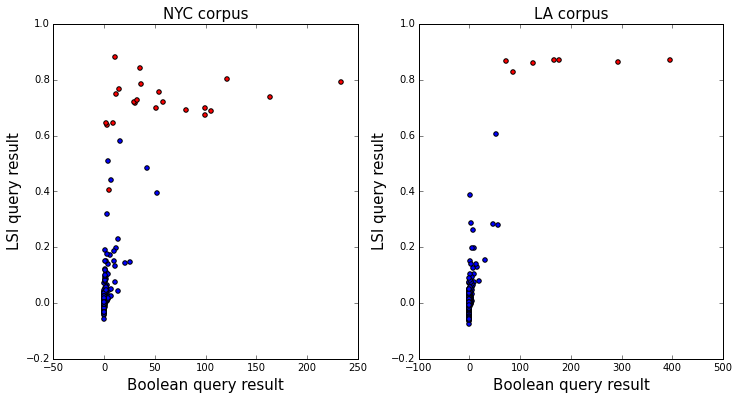

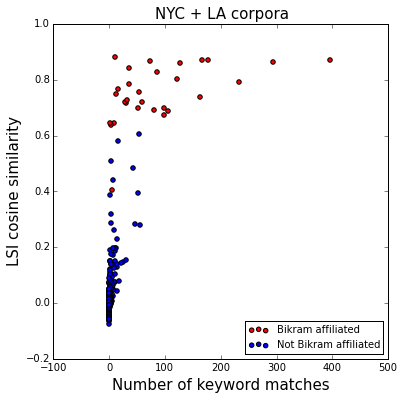

In [21]:
'''
Compare query results from LSI and from Boolean search on a single query, 
to fish out possibly interesting cases for further study.
'''
query  = 'bikram'

# Tokenize, clean up, and stem
query1 = utils.tokenize(query,lowercase=convert_lowercase,deacc=remove_accents)
if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
if remove_proper:    query1 = [word for word in query1 if word not in ppn]
if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
    
# LSI query against NYC corpus
vec_bow   = NYC_dictionary.doc2bow(query1,allow_update=False)
vec_tfidf = NYC_tfidf[vec_bow]
vec_lsi   = NYC_lsi[vec_tfidf] # Convert query to LSI space.
NYC_sims  = list(NYC_index[vec_lsi]) # Perform similarity query against NYC corpus.
print 'Number of NYC reviews = %i, similarity scores = %i' % (len(NYC_reviews),len(NYC_sims))

# LSI query against LA corpus
vec_bow   = LA_dictionary.doc2bow(query1,allow_update=False)
vec_tfidf = LA_tfidf[vec_bow]
vec_lsi   = LA_lsi[vec_tfidf] # Convert query to LSI space.
LA_sims   = list(LA_index[vec_lsi]) # Perform similarity query against LA corpus.
print 'Number of LA reviews = %i, similarity scores = %i' % (len(LA_reviews),len(LA_sims))

# Boolean query against NYC corpus
NYC_nmatch = [0]*len(NYC_reviews)
for ind,review in enumerate(NYC_reviews):
    review = review.lower()
    NYC_nmatch[ind] = sum([review.count(word) for word in query.split()])
        
# Boolean query against LA corpus
LA_nmatch = [0]*len(LA_reviews)
for ind,review in enumerate(LA_reviews):
    review = review.lower()
    LA_nmatch[ind] = sum([review.count(word) for word in query.split()])

# Print out results for Bikram-affiliated studios.
iprt = 0
print('\nBikram-affiliated studios in NYC, with (number of Boolean matches, LSI cosine similarity):')
for ind in range(len(NYC_names)):
    if 'bikram' in NYC_names[ind].lower():
        iprt += 1
        print('%i. (%i,%f): %s' %(iprt,NYC_nmatch[ind],NYC_sims[ind],NYC_names[ind]))
print('\nBikram-affiliated studios in LA, with (number of Boolean matches, LSI cosine similarity):')
for ind in range(len(LA_reviews)):
    if 'bikram' in LA_names[ind].lower():
        iprt += 1
        print('%i. (%i,%f): %s' %(iprt,LA_nmatch[ind],LA_sims[ind],LA_names[ind]))
        
# Make correlation plots
NYCb_nmatch1 = []
NYCb_sims1   = []
NYCn_nmatch1 = []
NYCn_sims1   = []
LAb_nmatch1  = []
LAb_sims1    = []
LAn_nmatch1  = []
LAn_sims1    = []
for ibiz in range(len(NYC_names)):
    if NYC_nmatch[ibiz] >= 0:
        if 'bikram' in NYC_names[ibiz].lower():
            NYCb_nmatch1.append(NYC_nmatch[ibiz])
            NYCb_sims1.append(NYC_sims[ibiz])
        else:
            NYCn_nmatch1.append(NYC_nmatch[ibiz])
            NYCn_sims1.append(NYC_sims[ibiz])
for ibiz in range(len(LA_names)):
    if LA_nmatch[ibiz] >= 0:
        if 'bikram' in LA_names[ibiz].lower():
            LAb_nmatch1.append(LA_nmatch[ibiz])
            LAb_sims1.append(LA_sims[ibiz])
        else:
            LAn_nmatch1.append(LA_nmatch[ibiz])
            LAn_sims1.append(LA_sims[ibiz])

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(NYCb_nmatch1,NYCb_sims1,c='red')
ax[0].scatter(NYCn_nmatch1,NYCn_sims1,c='blue')
ax[0].set_xlabel("Boolean query result",fontsize=15)
ax[0].set_ylabel("LSI query result",fontsize=15)
ax[0].set_title("NYC corpus",fontsize=15)
ax[1].scatter(LAb_nmatch1,LAb_sims1,c='red')
ax[1].scatter(LAn_nmatch1,LAn_sims1,c='blue')
ax[1].set_xlabel("Boolean query result",fontsize=15)
ax[1].set_ylabel("LSI query result",fontsize=15)
ax[1].set_title("LA corpus",fontsize=15)
plt.show()

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(6,6))
ax.scatter(NYCb_nmatch1,NYCb_sims1,c='red',label='Bikram affiliated')
ax.scatter(LAb_nmatch1,LAb_sims1,c='red')
ax.scatter(NYCn_nmatch1,NYCn_sims1,c='blue',label='Not Bikram affiliated')
ax.scatter(LAn_nmatch1,LAn_sims1,c='blue')
ax.set_xlabel("Number of keyword matches",fontsize=15)
ax.set_ylabel("LSI cosine similarity",fontsize=15)
ax.set_title("NYC + LA corpora",fontsize=15)
ax.legend(prop={'size': 10},loc="lower right")
plt.show()
#fig.savefig("LSI_vs_BM_m0.pdf")

<a id='section10'></a>
[Back to top](#section1)

## Investigate 'prenatal pregnant pregnancy' query

NYC: Number of reviews = 560, similarity scores = 560
     Query = "prenatal pregnant pregnancy", bag of words = "['prenat', 'pregnant', 'pregnanc']"

LA:  Number of reviews = 749, similarity scores = 749
     Query = "prenatal pregnant pregnancy", bag of words = "['prenat', 'pregnanc', 'pregnant']"

NYC businesses:
1. (23,0.904853): Lila Yoga, Dharma & Wellness [at] 302 Bowery, New York, NY 10012
2. (14,0.851919): Land Yoga [at] 2116 Frederick Douglass Blvd, Manhattan, NY 10026
3. (4,0.872171): Elahi Yoga [at] New York, NY
4. (5,0.935067): Yoga With Harper Chang [at] 
5. (4,0.676584): Simplyoga Institute [at] 428 Springfield Ave, Summit, NJ 07901
6. (9,0.768212): Prenatal & Postnatal Yoga Staten Island [at] 3980 Victory Blvd, Staten Island, NY 10314
7. (78,0.852013): Prenatal Yoga Center [at] 251 W 72nd St, New York, NY 10023

LA businesses:
8. (62,0.660216): Silver Lake Yoga [at] 2810 1/2 Glendale Blvd, Los Angeles, CA 90039
9. (37,0.866762): Ma Yoga Sherman Oaks - Bini Birth [at] 
1

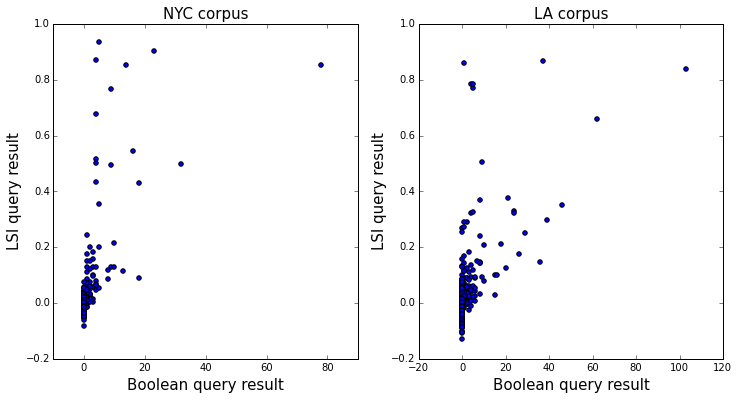

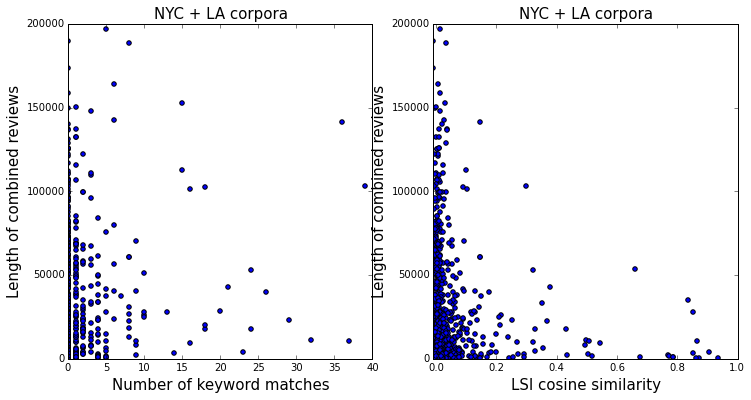

In [22]:
'''
Compare query results from LSI and from Boolean search on a single query, 
to fish out possibly interesting cases for further study.
'''
bquery = 'prenatal pregnant pregnancy'
lquery = 'prenatal yoga teaches pregnant women to relax, breathe, and appreciate change in their body'+\
         ' it helps alleviate ailments such as lower back pain and leg cramps'
lquery = bquery
    
# Tokenize, clean up, and stem
query1 = utils.tokenize(lquery,lowercase=convert_lowercase,deacc=remove_accents)
if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
if remove_proper:    query1 = [word for word in query1 if word not in ppn]
if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
    
# LSI query against NYC corpus
vec_bow   = NYC_dictionary.doc2bow(query1,allow_update=False)
vec_tfidf = NYC_tfidf[vec_bow]
vec_lsi   = NYC_lsi[vec_tfidf] # Convert query to LSI space.
NYC_sims  = list(NYC_index[vec_lsi]) # Perform similarity query against NYC corpus.
print 'NYC: Number of reviews = %i, similarity scores = %i' % (len(NYC_reviews),len(NYC_sims))
print('     Query = "%s", bag of words = "%s"' %(lquery,[str(NYC_dictionary[ind[0]]) for ind in vec_bow]))
    
# LSI query against LA corpus
vec_bow   = LA_dictionary.doc2bow(query1,allow_update=False)
vec_tfidf = LA_tfidf[vec_bow]
vec_lsi   = LA_lsi[vec_tfidf] # Convert query to LSI space.
LA_sims   = list(LA_index[vec_lsi]) # Perform similarity query against LA corpus.
print '\nLA:  Number of reviews = %i, similarity scores = %i' % (len(LA_reviews),len(LA_sims))
print('     Query = "%s", bag of words = "%s"' %(lquery,[str(LA_dictionary[ind[0]]) for ind in vec_bow]))

# Boolean query against NYC corpus
NYC_nmatch = [0]*len(NYC_reviews)
for ind,review in enumerate(NYC_reviews):
    review = review.lower()
    NYC_nmatch[ind] = sum([review.count(word) for word in bquery.split()])
        
# Boolean query against LA corpus
LA_nmatch = [0]*len(LA_reviews)
for ind,review in enumerate(LA_reviews):
    review = review.lower()
    LA_nmatch[ind] = sum([review.count(word) for word in bquery.split()])
    
# Print reviews for interesting cases.
print('\nNYC businesses:')
iprt = 0
for ibiz in range(len(NYC_names)):
    if NYC_nmatch[ibiz] >= 0 and NYC_sims[ibiz] >= 0.6:
        iprt += 1
        print('%i. (%i,%f): %s' %(iprt,NYC_nmatch[ibiz],NYC_sims[ibiz],NYC_names[ibiz]))
#        print NYC_reviews[ibiz]
print('\nLA businesses:')
for ibiz in range(len(LA_names)):
    if LA_nmatch[ibiz] >= 0 and LA_sims[ibiz] >= 0.6:
        iprt += 1
        print('%i. (%i,%f): %s' %(iprt,LA_nmatch[ibiz],LA_sims[ibiz],LA_names[ibiz]))
#        print LA_reviews[ibiz]
    
# Make correlation plots
NYC_nmatch1 = []
NYC_sims1   = []
NYC_rlen    = []
LA_nmatch1  = []
LA_sims1    = []
LA_rlen     = []
for ibiz in range(len(NYC_names)):
    if NYC_nmatch[ibiz] >= 0:
        NYC_nmatch1.append(NYC_nmatch[ibiz])
        NYC_sims1.append(NYC_sims[ibiz])
        NYC_rlen.append(len(NYC_reviews[ibiz]))
for ibiz in range(len(LA_names)):
    if LA_nmatch[ibiz] >= 0:
        LA_nmatch1.append(LA_nmatch[ibiz])
        LA_sims1.append(LA_sims[ibiz])
        LA_rlen.append(len(LA_reviews[ibiz]))

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(NYC_nmatch1,NYC_sims1)
ax[0].set_xlabel("Boolean query result",fontsize=15)
ax[0].set_ylabel("LSI query result",fontsize=15)
ax[0].set_title("NYC corpus",fontsize=15)
ax[1].scatter(LA_nmatch1,LA_sims1)
ax[1].set_xlabel("Boolean query result",fontsize=15)
ax[1].set_ylabel("LSI query result",fontsize=15)
ax[1].set_title("LA corpus",fontsize=15)
plt.show()

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(NYC_nmatch1,NYC_rlen)
ax[0].scatter(LA_nmatch1,LA_rlen)
ax[0].set_xlabel("Number of keyword matches",fontsize=15)
ax[0].set_ylabel("Length of combined reviews",fontsize=15)
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,200000)
ax[0].set_title("NYC + LA corpora",fontsize=15)
ax[1].scatter(NYC_sims1,NYC_rlen)
ax[1].scatter(LA_sims1,LA_rlen)
ax[1].set_xlabel("LSI cosine similarity",fontsize=15)
ax[1].set_ylabel("Length of combined reviews",fontsize=15)
ax[1].set_xlim(-0.01,1.0)
ax[1].set_ylim(0,200000)
ax[1].set_title("NYC + LA corpora",fontsize=15)
plt.show()

<a id='section11'></a>
[Back to top](#section1)

## Investigate 'yoga nidra' query

NYC: Number of reviews = 560, similarity scores = 560
     Query = "nidra", bag of words = "['nidra']"
     Number of similarity scores above 0.1: 68
     Number of keyword counts above 1: 8

LA:  Number of reviews = 749, similarity scores = 749
     Query = "nidra", bag of words = "['nidra']"
     Number of similarity scores above 0.1: 127
     Number of keyword counts above 1: 7

NYC businesses:
1. (2,0.140369): Stanton Street Yoga [at] 196A Stanton St, New York, NY 10002
2. (1,0.093169): Integral Yoga Institute [at] 227 W 13th St, New York, NY 10011
3. (2,0.193317): Ishta Yoga [at] 56 E 11th St, New York, NY 10003
4. (1,0.156992): Sivananda Yoga Vedanta Center [at] 243 W 24th St, New York, NY 10011
5. (1,0.057642): Area Yoga [at] 389 Court St, Brooklyn, NY 11231
6. (1,0.158138): Ishta Yoga [at] 1026 3rd Ave, New York, NY 10065
7. (1,0.149522): Shakti Yoga Center [at] 3 Victory Blvd, Staten Island, NY 10301
8. (1,0.916270): Yoga Nidra Studio [at] 7217 13th Ave, Brooklyn, NY 11228

LA

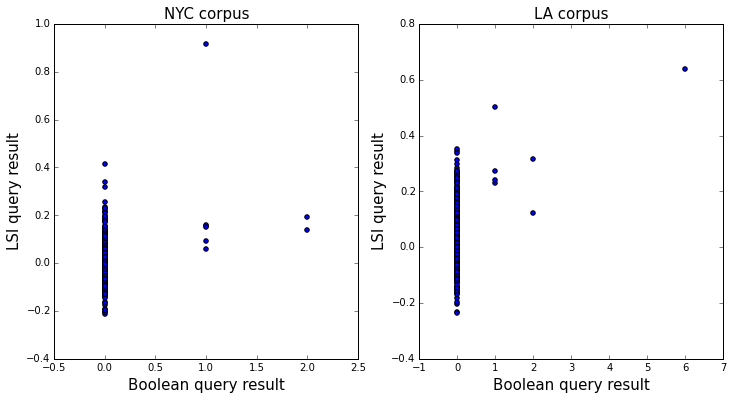

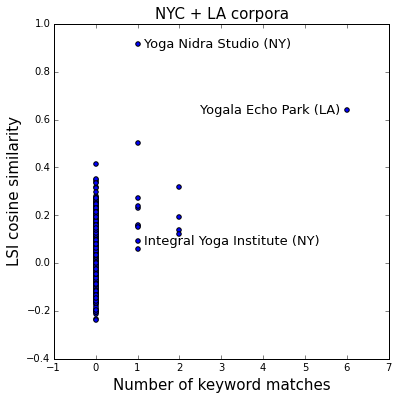

In [23]:
'''
Compare query results from LSI and from Boolean search on a single query, 
to fish out possibly interesting cases for further study.
'''
bquery = 'nidra'
lquery = 'Yoga Nidra, or yogic sleep, or lucid sleeping, is the deepest state of relaxation '+\
         'one can attain while still maintaining full consciousness'
lquery = bquery

# Tokenize, clean up, and stem
query1 = utils.tokenize(lquery,lowercase=convert_lowercase,deacc=remove_accents)
if remove_stopwords: query1 = [word for word in query1 if word not in stoplist]
if remove_proper:    query1 = [word for word in query1 if word not in ppn]
if stem_tokens:      query1 = [stemmer.stem(word) for word in query1]
    
# Boolean query against NYC corpus
NYC_nmatch = [0]*len(NYC_reviews)
for ind,review in enumerate(NYC_reviews):
    review = review.lower()
    NYC_nmatch[ind] = sum([review.count(word) for word in bquery.split()])
nqat_bn    = sum([1 for match in NYC_nmatch if match>=1])
        
# Boolean query against LA corpus
LA_nmatch = [0]*len(LA_reviews)
for ind,review in enumerate(LA_reviews):
    review = review.lower()
    LA_nmatch[ind] = sum([review.count(word) for word in bquery.split()])
nqat_bl    = sum([1 for match in LA_nmatch if match>=1])
    
# LSI query against NYC corpus
vec_bow   = NYC_dictionary.doc2bow(query1,allow_update=False)
vec_tfidf = NYC_tfidf[vec_bow]
vec_lsi   = NYC_lsi[vec_tfidf] # Convert query to LSI space.
NYC_sims  = list(NYC_index[vec_lsi]) # Perform similarity query against NYC corpus.
nqat_ln   = sum([1 for sim in NYC_sims if sim>=0.1])
print 'NYC: Number of reviews = %i, similarity scores = %i' % (len(NYC_reviews),len(NYC_sims))
print('     Query = "%s", bag of words = "%s"' %(lquery,[str(NYC_dictionary[ind[0]]) for ind in vec_bow]))
print('     Number of similarity scores above 0.1: %i' %nqat_ln)
print('     Number of keyword counts above 1: %i' %nqat_bn)
    
# LSI query against LA corpus
vec_bow   = LA_dictionary.doc2bow(query1,allow_update=False)
vec_tfidf = LA_tfidf[vec_bow]
vec_lsi   = LA_lsi[vec_tfidf] # Convert query to LSI space.
LA_sims   = list(LA_index[vec_lsi]) # Perform similarity query against LA corpus.
nqat_ll   = sum([1 for sim in LA_sims if sim>=0.1])
print '\nLA:  Number of reviews = %i, similarity scores = %i' % (len(LA_reviews),len(LA_sims))
print('     Query = "%s", bag of words = "%s"' %(lquery,[str(LA_dictionary[ind[0]]) for ind in vec_bow]))
print('     Number of similarity scores above 0.1: %i' %nqat_ll)
print('     Number of keyword counts above 1: %i' %nqat_bl)

# Print reviews for interesting cases.
print('\nNYC businesses:')
iprt = 0
for ibiz in range(len(NYC_names)):
    if NYC_nmatch[ibiz] >= 1 and NYC_sims[ibiz] >= -1.0:
        iprt += 1
        print('%i. (%i,%f): %s' %(iprt,NYC_nmatch[ibiz],NYC_sims[ibiz],NYC_names[ibiz]))
#        print('%s\n' %NYC_reviews[ibiz])
print('\nLA businesses:')
for ibiz in range(len(LA_names)):
    if LA_nmatch[ibiz] >= 1 and LA_sims[ibiz] >= -1.0:
        iprt += 1
        print('%i. (%i,%f): %s' %(iprt,LA_nmatch[ibiz],LA_sims[ibiz],LA_names[ibiz]))
#        print('%s\n' %LA_reviews[ibiz])

# Make correlation plots
NYC_nmatch1 = []
NYC_sims1   = []
LA_nmatch1  = []
LA_sims1    = []
for ibiz in range(len(NYC_names)):
    if NYC_nmatch[ibiz] >= 0:
        NYC_nmatch1.append(NYC_nmatch[ibiz])
        NYC_sims1.append(NYC_sims[ibiz])
for ibiz in range(len(LA_names)):
    if LA_nmatch[ibiz] >= 0:
        LA_nmatch1.append(LA_nmatch[ibiz])
        LA_sims1.append(LA_sims[ibiz])

fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
ax[0].scatter(NYC_nmatch1,NYC_sims1,c='blue')
ax[0].set_xlabel("Boolean query result",fontsize=15)
ax[0].set_ylabel("LSI query result",fontsize=15)
ax[0].set_title("NYC corpus",fontsize=15)
ax[1].scatter(LA_nmatch1,LA_sims1,c='blue')
ax[1].set_xlabel("Boolean query result",fontsize=15)
ax[1].set_ylabel("LSI query result",fontsize=15)
ax[1].set_title("LA corpus",fontsize=15)
plt.show()

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(6,6))
for ibiz in range(len(NYC_names)):
    shiftx = NYC_nmatch[ibiz]+0.15
    shifty = NYC_sims[ibiz]
    if "Integral Yoga Institute" in NYC_names[ibiz]:
        word = "Integral Yoga Institute (NY)"
    elif "Yoga Nidra Studio" in NYC_names[ibiz]:
        word = "Yoga Nidra Studio (NY)"
    else:
        word = ''
    if word != '':
        ax.text(shiftx, shifty, word, ha='left', va='center', size=13)
for ibiz in range(len(LA_names)):
    shiftx = LA_nmatch[ibiz]-3.5
    shifty = LA_sims[ibiz]
    if "Yogala Echo Park" in LA_names[ibiz]:
        word = "Yogala Echo Park (LA)"
    else:
        word = ''
    if word != '':
        ax.text(shiftx, shifty, word, ha='left', va='center', size=13)
ax.scatter(NYC_nmatch1,NYC_sims1,c='blue')
ax.scatter(LA_nmatch1,LA_sims1,c='blue')
ax.set_xlabel("Number of keyword matches",fontsize=15)
ax.set_ylabel("LSI cosine similarity",fontsize=15)
ax.set_title("NYC + LA corpora",fontsize=15)
plt.show()
#fig.savefig("LSI_vs_BM_YogaNidra.pdf")

<a id='section12'></a>
[Back to top](#section1)

##Plot document retrieval probabilities for various queries, LA corpus versus NYC corpus

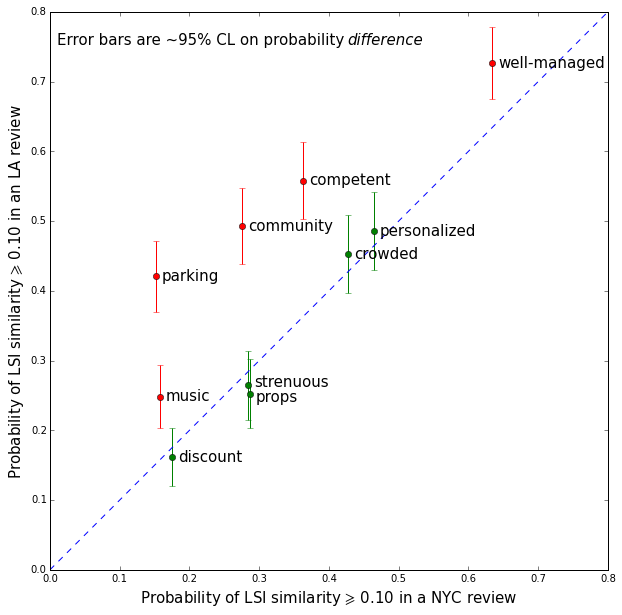

In [24]:
'''
Plot some LSI query results, LA versus NYC.
'''

# Select the queries to plot
ivalues = [14,16,17,19,20,22,23,24,26,27]
xval = []
yval = []
word = []
xerr = []
yerr = []
sgnf = []
for i in ivalues:
    if NYC_prob[i]>0.005 and LA_prob[i]>0.005:
        xval.append(NYC_prob[i])
        yval.append(LA_prob[i])
        word.append(queries[i].split()[0])
        xerr.append(0.0)
        yerr.append(sigma[i])
        sgnf.append(sgnfcnc[i])
npts = len(word)
xmax = 0.8
ymax = 0.8

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,10))
for i in range(npts):
    shiftx = xval[i]+0.01
    shifty = yval[i]
    if word[i] == "strenuous":
        shifty += 0.005
    elif word[i] == "props":
        shifty -= 0.005
    ax.text(shiftx, shifty, word[i], ha='left', va='center', size=15)
    if sgnf[i] > 2.0:
        ax.errorbar(xval[i], yval[i], yerr=yerr[i], fmt='ro')
    else:
        ax.errorbar(xval[i], yval[i], yerr=yerr[i], fmt='go')
ax.text(0.01,0.95*ymax,"Error bars are ~95% CL on probability", ha='left', va='center',size=15)
ax.text(0.427, 0.95*ymax, "difference", ha='left', va='center', size=15, style='oblique' )
ax.set_xlabel(r"Probability of LSI similarity $\geqslant$ {0:.2f} in a NYC review".format(sim_threshold),fontsize=15)
ax.set_ylabel(r"Probability of LSI similarity $\geqslant$ {0:.2f} in an LA review".format(sim_threshold),fontsize=15)
ax.set_xlim(0.0,xmax)
ax.set_ylim(0.0,ymax)
ax.plot([0.0,xmax], [0.0,xmax], 'b--')
plt.show()
#fig.savefig("yoga_keywords_lsi1.png")

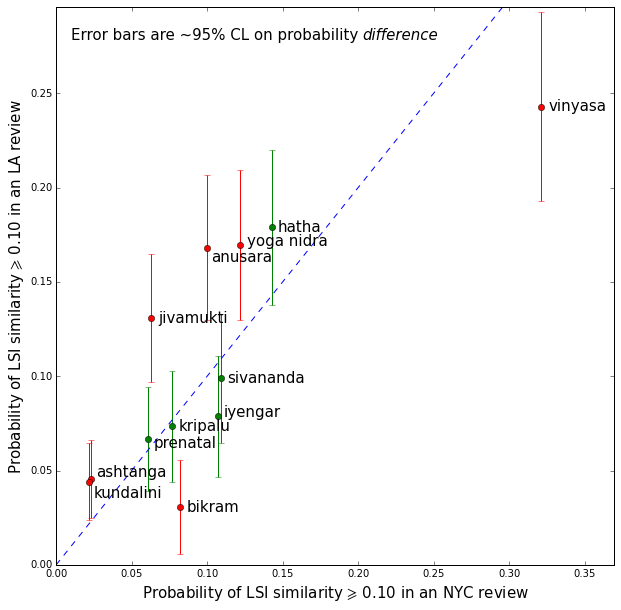

In [25]:
'''
Plot the next set of LSI query results, LA versus NYC.
'''

# Select the queries to plot
ivalues = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
xval = []
yval = []
word = []
xerr = []
yerr = []
sgnf = []
for i in ivalues:
    if NYC_prob[i]>0.005 and LA_prob[i]>0.005:
        xval.append(NYC_prob[i])
        yval.append(LA_prob[i])
        word.append(queries[i].split()[0])
        xerr.append(0.0)
        yerr.append(sigma[i])
        sgnf.append(sgnfcnc[i])
npts = len(word)
xmax = 1.15*max(xval)
ymax = 1.01*max([yval[i]+yerr[i] for i in range(len(yval))])

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,10))
for i in range(npts):
    shiftx = xval[i]+0.005
    shifty = yval[i]
    if word[i] == 'nidra':
        word[i] = 'yoga nidra'
        shifty += 0.002
    elif word[i] == 'anusara':
        shiftx -= 0.002
        shifty -= 0.005
    elif word[i] == 'iyengar':
        shifty += 0.002
    elif word[i] == 'prenatal':
        shifty -= 0.002
    elif word[i] == 'ashtanga':
        shiftx -= 0.001
        shifty += 0.004
    elif word[i] == 'kundalini':
        shiftx -= 0.001
        shifty -= 0.006
    ax.text(shiftx, shifty, word[i], ha='left', va='center', size=15)
    if sgnf[i] > 2.0:
        ax.errorbar(xval[i], yval[i], yerr=yerr[i], fmt='ro')
    else:
        ax.errorbar(xval[i], yval[i], yerr=yerr[i], fmt='go')
ax.text(0.01,0.95*ymax,"Error bars are ~95% CL on probability", ha='left', va='center',size=15)
ax.text(0.203, 0.95*ymax, "difference", ha='left', va='center', size=15, style='oblique' )
ax.set_xlabel(r"Probability of LSI similarity $\geqslant$ {0:.2f} in an NYC review".format(sim_threshold),fontsize=15)
ax.set_ylabel(r"Probability of LSI similarity $\geqslant$ {0:.2f} in an LA review".format(sim_threshold),fontsize=15)
ax.set_xlim(0.0,xmax)
ax.set_ylim(0.0,ymax)
ax.plot([0.0,xmax], [0.0,xmax], 'b--')
plt.show()
#fig.savefig("yoga_styles_lsi1.png")

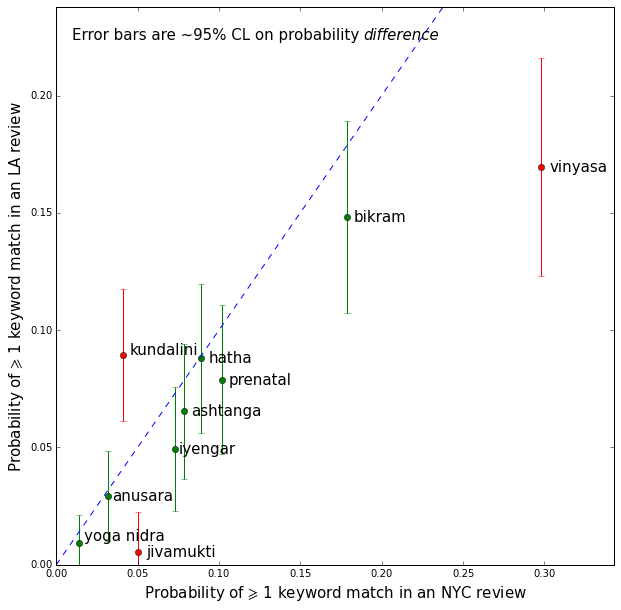

In [26]:
'''
Plot Boolean query results, LA versus NYC.
'''
# Select the queries to plot
ivalues = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
xval = []
yval = []
word = []
xerr = []
yerr = []
sgnf = []
for i in ivalues:
    if NYC_bm_prob[i]>0.005 and LA_bm_prob[i]>0.005:
        xval.append(NYC_bm_prob[i])
        yval.append(LA_bm_prob[i])
        word.append(queries[i].split()[0])
        xerr.append(0.0)
        yerr.append(bm_sigma[i])
        sgnf.append(bm_sgnfcnc[i])
npts = len(word)
xmax = 1.15*max(xval)
ymax = 1.1*max([yval[i]+yerr[i] for i in range(len(yval))])

fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,10))
for i in range(npts):
    shiftx = xval[i]+0.005
    shifty = yval[i]
    if word[i] == 'nidra':
        word[i] = 'yoga nidra'
        shiftx -= 0.002
        shifty += 0.003
    elif word[i] == 'iyengar':
        shiftx -= 0.002
    elif word[i] == 'kundalini':
        shifty += 0.002
    elif word[i] == 'anusara':
        shiftx -= 0.002
    ax.text(shiftx, shifty, word[i], ha='left', va='center', size=15)
    if sgnf[i] > 2.0:
        ax.errorbar(xval[i], yval[i], yerr=yerr[i], fmt='ro')
    else:
        ax.errorbar(xval[i], yval[i], yerr=yerr[i], fmt='go')
ax.text(0.01,0.95*ymax,"Error bars are ~95% CL on probability", ha='left', va='center',size=15)
ax.text(0.189, 0.95*ymax, "difference", ha='left', va='center', size=15, style='oblique' )
ax.set_xlabel(r'Probability of $\geqslant$ {0:d} keyword match in an NYC review'.format(kmatch_threshold),fontsize=15)
ax.set_ylabel(r'Probability of $\geqslant$ {0:d} keyword match in an LA review'.format(kmatch_threshold),fontsize=15)
ax.set_xlim(0.0,xmax)
ax.set_ylim(0.0,ymax)
ax.plot([0.0,xmax], [0.0,xmax], 'b--')
plt.show()
#fig.savefig("yoga_styles_bm1.png")

For query "vinyasa", P(LSI)-P(KM) = 0.023214 (NYC), 0.073431 (LA)
For query "anusara", P(LSI)-P(KM) = 0.067857 (NYC), 0.138852 (LA)
For query "ashtanga", P(LSI)-P(KM) = -0.055357 (NYC), -0.020027 (LA)
For query "jivamukti", P(LSI)-P(KM) = 0.012500 (NYC), 0.125501 (LA)
For query "hatha", P(LSI)-P(KM) = 0.053571 (NYC), 0.090788 (LA)
For query "iyengar", P(LSI)-P(KM) = 0.033929 (NYC), 0.029372 (LA)
For query "kripalu", P(LSI)-P(KM) = 0.073214 (NYC), 0.069426 (LA)
For query "bikram", P(LSI)-P(KM) = -0.096429 (NYC), -0.117490 (LA)
For query "sivananda", P(LSI)-P(KM) = 0.103571 (NYC), 0.096128 (LA)
For query "viniyoga", P(LSI)-P(KM) = -0.001786 (NYC), -0.001335 (LA)
For query "yogafit", P(LSI)-P(KM) = 0.000000 (NYC), -0.002670 (LA)
For query "kundalini", P(LSI)-P(KM) = -0.019643 (NYC), -0.045394 (LA)
For query "nidra", P(LSI)-P(KM) = 0.107143 (NYC), 0.160214 (LA)
For query "prenatal", P(LSI)-P(KM) = -0.041071 (NYC), -0.012016 (LA)


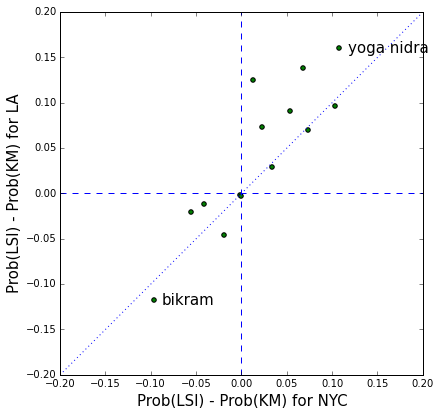

In [27]:
'''
Make a plot of (LSI probability - Boolean matching probability) for LA versus NYC
'''
# Select the queries to plot
ivalues = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
xval = []
yval = []
word = []
for i in ivalues:
    dProbNYC = NYC_prob[i] - NYC_bm_prob[i]
    dProbLA  = LA_prob[i]  - LA_bm_prob[i]
    xval.append(dProbNYC)
    yval.append(dProbLA)
    query = queries[i].split()[0]
    print('For query "%s", P(LSI)-P(KM) = %f (NYC), %f (LA)' %(query,dProbNYC,dProbLA))
    if query=='bikram' or query=='nidra':
        if query=='nidra': query='yoga nidra'
        word.append(query)
    else:
        word.append('')
npts = len(ivalues)

xmin = -0.20
xmax = 0.20
ymin = -0.20
ymax = 0.20
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(6.5,6.5))
ax.scatter(xval,yval,c="green")
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel('Prob(LSI) - Prob(KM) for NYC',fontsize=15)
ax.set_ylabel('Prob(LSI) - Prob(KM) for LA',fontsize=15)
ax.plot([xmin,xmax], [0.0,0.0], 'b--')
ax.plot([0.0,0.0], [ymin,ymax], 'b--')
ax.plot([xmin,xmax], [ymin,ymax], 'b:')
for i in range(npts):
    shiftx = xval[i]+0.010
    shifty = yval[i]
    ax.text(shiftx, shifty, word[i], ha='left', va='center', size=15)
plt.show()
fig.savefig("yoga_styles_dp.png")

<a id='section13'></a>
[Back to top](#section1)

##Create a json file with query info about each business in NYC and LA

In [36]:
'''
Open existing json file with yoga business names, street addresses and geocoordinates,
and add website information and query vector.  Create new json file with the result.
'''
import json
#
# First New York City:
json_in  = "NYC_yoga_studios_v1.json"
json_out = "NYC_yoga_studios_v3.json"
    
with open(json_in) as json_data:
    old_json = json.load(json_data)
print('Number of businesses listed in old NYC json: %i' % len(old_json))

new_json = []
for i in range(len(NYC_names)):
    if NYC_names[i] != "":
        biz   = NYC_names[i].split(" [at] ")
        jlist = [j for j,studio in enumerate(old_json) if studio["name"]==biz[0] and studio["address"]==biz[1]]
        if jlist == []:
            print('Studio "%s" not found in NYC json' % NYC_names[i])
        else:
            if len(jlist) > 1: print('Studio "%s" not unique in NYC json' % NYC_names[i])
            j = jlist[0]
            biz               = {}
            biz["name"]       = old_json[j]["name"]
            biz["address"]    = old_json[j]["address"]
            biz["website"]    = NYC_websites[i]
            biz["lon"]        = old_json[j]["lon"]
            biz["lat"]        = old_json[j]["lat"]
            biz["lsi_scores"] = [float(NYC_lsi_scores[qn][i]) for qn in range(len(queries))]
            biz["bkm_scores"] = [NYC_bm_scores[qn][i] for qn in range(len(queries))]
            new_json.append(biz)
print('Number of businesses listed in new NYC json: %i' % len(new_json))

with open (json_out, 'w') as outfile:
    json.dump(new_json,outfile,indent=4,sort_keys=False)
#    
# Now Los Angeles:
json_in  = "LA_yoga_studios_v1.json"
json_out = "LA_yoga_studios_v3.json"

with open(json_in) as json_data:
    old_json = json.load(json_data)
print('Number of businesses listed in old LA json: %i' % len(old_json))

new_json = []
for i in range(len(LA_names)):
    if LA_names[i] != "":
        biz   = LA_names[i].split(" [at] ")
        jlist = [j for j,studio in enumerate(old_json) if studio["name"]==biz[0] and studio["address"]==biz[1]]
        if jlist == []:
            print('Studio "%s" not found in LA json' % LA_names[i])
        else:
            if len(jlist) > 1: print('Studio "%s" not unique in LA json' % LA_names[i])
            j = jlist[0]
            biz               = {}
            biz["name"]       = old_json[j]["name"]
            biz["address"]    = old_json[j]["address"]
            biz["website"]    = LA_websites[i]
            biz["lon"]        = old_json[j]["lon"]
            biz["lat"]        = old_json[j]["lat"]
            biz["lsi_scores"] = [float(LA_lsi_scores[qn][i]) for qn in range(len(queries))]
            biz["bkm_scores"] = [LA_bm_scores[qn][i] for qn in range(len(queries))]
            new_json.append(biz)
print('Number of businesses listed in new LA json: %i' % len(new_json))

with open (json_out, 'w') as outfile:
    json.dump(new_json,outfile,indent=4,sort_keys=False)

Number of businesses listed in old NYC json: 791
Studio "Yoga With Harper Chang [at] " not found in NYC json
Studio "Skye-Yoga [at] " not found in NYC json
Number of businesses listed in new NYC json: 558
Number of businesses listed in old LA json: 736
Studio "Ma Yoga Sherman Oaks - Bini Birth [at] " not found in LA json
Studio "Three Circle Flow Hypnotherapy [at] " not found in LA json
Studio "Healing with Jenn [at] " not found in LA json
Studio "Pura Healing [at] " not found in LA json
Studio "Pure Light Wellness [at] " not found in LA json
Studio "Cassie Cherney Yoga [at] " not found in LA json
Studio "Ma Yoga Beverly Hills - Music Together [at] " not found in LA json
Studio "CHI - Create Heal Inspire [at] " not found in LA json
Studio "Stress Away [at] " not found in LA json
Studio "Soulspaces Yoga with Stefani Manger [at] " not found in LA json
Studio "Sacred Dreamer [at] " not found in LA json
Studio "Aria Mayland [at] " not found in LA json
Studio "OM Lotus [at] " not found in L

### Some unusual words found in the NYC and LA corpora:

In New York City corpus:

* alma = Nueva Alma studio
* bonda = Bonda Yoga Studio
* daya = Daya Yoga Studio
* elahi = Elahi Yoga in the UES
* hys = Harlem Yoga Studio
* ikm = International Krav Maga
* joschi = Joschi Body Bodega
* krav maga = self-defense system developed for the military in Israel
* mrg = MRG fitness studio in Staten Island
* tenafly = borough in Bergen County, New Jersey
* vdy = Brooklyn Vindhya Yoga
* yith = Yoga in the (Jersey City) Heights

In Los Angeles corpus:

* cpy is "Core Power Yoga"
* bar could be juice bar, or simply bar, or barely, barefoot,...
* yas refers to "Yoga And Spinning", a fitness center that provides both yoga classes and indoor cycling.